# W207 Final Project
### Kaggle Competition
[San Francisco Crime Statistics](https://www.kaggle.com/c/sf-crime)

In this project, we worked on predicting categories of crime in San Francisco for years 2003 to 2015. The data included time, date, location, and neighborhood as some of the features. The training data included additional crime description/resolution information that was not found on the data to be predicted for. 
  
###  Team Members
Chuck Bolin, Matthew Burke, Yun-Hui Fan

## Table of Contents
### Library / Data Loading
### Feature Engineering
* Date Attributes
* XY Coordinates
* Address Parsing
#### Data Preparation
* Train/Test Split
* PCA
### Model Evaluation
* Logsitic Regression
    - Optimization
    - Error Analysis
* KNN
* Random Forest
* Naive Bayes
    - Bernoulli
    - Gaussian
* XGBoost
### Final Model Predictions
* Data Prep/Prediction
* Submissions
    - Models
    - Results

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import utils

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

### Data Loading
Load in training and test data to variables

In [4]:
train_all = pd.read_csv('../data/train.csv', delimiter=',', parse_dates=['Dates'])
# test_final contains data which will be submitted to kaggle after predicting categories
# Includes ID field not found in training data
# Does not include description, category or resolution fields in training data
test_final = pd.read_csv('../data/test.csv', delimiter=',')

## Feature Engineering

### Date Features
Take the single time to create features for Year, Month, Day and Hour

In [5]:
def dateAttributes(df):
    df = df.copy()
    df['Year'] = pd.DatetimeIndex(df['Dates']).year
    df['Month'] = pd.DatetimeIndex(df['Dates']).month
    df['Day'] = pd.DatetimeIndex(df['Dates']).day
    df['Hour'] = pd.DatetimeIndex(df['Dates']).hour
    return df

# Extract elements of dates
train_all = dateAttributes(train_all)

# Column names to binarize:
bin_cols = ['Year', 'Month', 'Hour', 'DayOfWeek', 'PdDistrict']

# Binarize columns identified above and add to dataframe
for column in bin_cols:
    dummies = pd.get_dummies(train_all[column])
    train_all[dummies.columns] = dummies

# Encode all categories into integers for use later
le = LabelEncoder()
labels_all = le.fit_transform(train_all['Category'])

    
#Extract categories names from encoder for use later
categories = le.classes_

### XY Coordinates
Round X and Y features to 2 decimal places, convert to strings and then combine into single value
Binarize new feature and concatenate to training data

In [6]:
fun = lambda x: str(round(x, 2))
temp = train_all['X'].map(fun) + train_all['Y'].map(fun)
lb = LabelBinarizer()
train_all = np.concatenate((train_all, lb.fit_transform(temp)), axis=1)

### Mapping Addresses
Extract street names from `Address` column and combine if multiple street names, i.e. for a city block.
Ultimately creates 12000+ features, which isn't necessarily more helpful than XY coordinates, especially since we are removing the block numbers which reduces precision even further.

In [33]:
add = train_all[:,6]
streets = []
for i in range(0,len(add)):
    matches = re.findall('[A-Z]{3,}|[0-9]+TH',add[i])
    if len(matches)==1:
        streets.append(matches[0])
    else:
        streets.append(''.join(matches))
print 'Total Street Name Features:', len(np.unique(streets))

Total Street Name Features: 12758


## Split Data Into Train/Test
Designate 1/3 of the data to be test data and the other 2/3 to be training data for development purposes

In [8]:
# Define fraction of data to be used as test data
fraction = 0.33

# Split data into training and test data/labels randomly according to fraction specified
train_labels, test_labels, train_data, test_data = train_test_split(labels_all, train_all, test_size=fraction)


print 'Check that data has been formed correctly:\n'

print 'Training data shape: ', train_data.shape
print 'Training labels shape: ', len(train_labels)#train_labels.shape

print 'Test data shape: ', test_data.shape
print 'Test labels shape: ', len(test_labels)#test_labels.shape

print('Train labels: ', len(np.unique(train_labels)))
print('Test  labels: ', len(np.unique(test_labels)))

print '\nTop row of training data:\n'

print train_data [0,]

Check that data has been formed correctly:

Training data shape:  (588292, 206)
Training labels shape:  588292
Test data shape:  (289757, 206)
Test labels shape:  289757
('Train labels: ', 39)
('Test  labels: ', 38)

Top row of training data:

[Timestamp('2015-04-04 00:01:00') 'LARCENY/THEFT' 'PETTY THEFT OF PROPERTY'
 'Saturday' 'NORTHERN' 'NONE' '2200 Block of POLK ST' -122.422076812058
 37.797126504747 2015 4 4 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


### PCA
Performing PCA on binarized Year, Month, Hour, DayOfWeek, District and XY coordinate

In [6]:
pca_mod = PCA(n_components=50).fit(train_all[:200000,12:])
for i in range(5,50,5):
    var = sum(pca_mod.explained_variance_ratio_[range(1,i)])
    print 'Components: ', '{:2}'.format(i), '    Variance Explained: ', var

Components:   5     Variance Explained:  0.0195971410648
Components:  10     Variance Explained:  0.0346923201463
Components:  15     Variance Explained:  0.0478148962278
Components:  20     Variance Explained:  0.0558327939406
Components:  25     Variance Explained:  0.0620686843686
Components:  30     Variance Explained:  0.0674808682207
Components:  35     Variance Explained:  0.0721162360068
Components:  40     Variance Explained:  0.0757859880138
Components:  45     Variance Explained:  0.078517611605


## Model Evaluation
We define subsets of the training and test data to use for development. Larger datasets will be used for full validation

`cols` is the set of columns for all binary variables

`knnCols` is the set of columns for integer-mapped categorical variables

In [ ]:
# Columns to use in baseline classification
cols = range(13, 206)
knnCols = range(7,13)

dev_data = train_data[:300000,:]
dev_labels = train_labels[:300000]

dev_test_data = test_data[:80000,:]
dev_test_labels = test_labels[:80000]

print('Train labels: ', len(np.unique(dev_labels)))
print('Test  labels: ', len(np.unique(dev_test_labels)))

### Logistic Regression
We tested logistic regression as a simple, baseline model since it is intuitive and the importance of prediction factors is easily identifiable. First we use a gridsearch on C values to find optimal parameters.

## NOTES FOR CHUCK/YUN-HUI
I tried running these, but they take forever using the full training data. If I lower them, however, I end up running into the error where the model does not actually predict one or two of the classes, and it errors out. 

L1 regularization parameters check first:

In [ ]:
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
penalty = ['l1']
solver = ['liblinear','sag']
params = {'C': c_values, 'penalty': penalty, 'solver': solver}
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=params, scoring='neg_log_loss')
grid.fit(train_data[:,cols], train_labels)
print grid
print grid.best_params_

L2 regularization parameters check:

In [ ]:
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
penalty = ['l2']
solver = ['newton-cg', 'lbfgs', 'sag']
params = {'C': c_values, 'penalty': penalty, 'solver': solver}
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=params, scoring='neg_log_loss')
grid.fit(dev_data[:,cols], dev_labels)
print grid
print grid.best_params_

In [32]:
lgr = LogisticRegression(C=0.3)
print 'Begin training'
lgr.fit(dev_data[:,cols], dev_labels)
print 'Completed training'

print 'Begin prediction'
pred_probs = lgr.predict_proba(dev_test_data[:,cols])
pred = lgr.predict(dev_test_data[:,cols])

print 'Completed prediction\n'

print 'Log score: ', metrics.log_loss(dev_test_labels, pred_probs, labels=range(0,39)), '\n'

print 'Accuracy: ', metrics.accuracy_score(dev_test_labels, pred), '\n'

print 'Probability prediction examples: ', pred_probs[0,]

Begin training
Completed training
Begin prediction
Completed prediction

Log score:  2.51519731138 

Accuracy:  0.2449125 

Probability prediction examples:  [ 0.01483811  0.15903765  0.00027453  0.00063634  0.03198766  0.00113978
  0.00415697  0.03510617  0.00215212  0.00062875  0.00026444  0.00027965
  0.00125853  0.00402579  0.00018967  0.00566952  0.05522211  0.00043416
  0.00031183  0.0400768   0.06087067  0.16393388  0.00017228  0.00058718
  0.00940559  0.02698002  0.00122659  0.04952153  0.00636652  0.00046899
  0.00679316  0.00085782  0.05084693  0.00017278  0.007653    0.11333209
  0.0451954   0.04709703  0.05082797]


This prediction did reasonably well as a baseline Kaggle submission. We look further into what types of mislabeling are happening. There is a very low actual accuracy since there are so many labels, but a confusion matrix will help us narrow down where any incorrect classification trends are occurring.

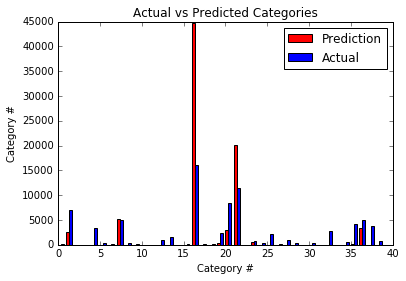

Confusion matrix, without normalization
[[  0   7   0 ...,  16   0   0]
 [  0 448   0 ..., 311   0   0]
 [  0   0   0 ...,   2   0   0]
 ..., 
 [  0 166   0 ..., 780   0   0]
 [  0 124   0 ..., 104   0   0]
 [  0  66   0 ...,  30   0   0]]


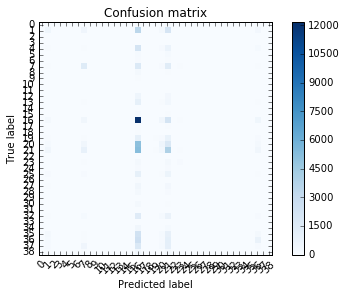

In [61]:
fig, ax = plt.subplots()
width = [0.35]
pred_chart = ax.bar(range(0,39), np.bincount(pred, minlength=39), width, color='r')
actual_chart = ax.bar(np.array(range(0,39)) + width, np.bincount(dev_test_labels, minlength=39), width, color='b')

ax.set_ylabel('Category #')
ax.set_xlabel('Category #')
ax.set_title('Actual vs Predicted Categories')

ax.legend((pred_chart[0], actual_chart[0]), ('Prediction', 'Actual'))

plt.show()

# Function taken from scikit-learn's confusion matrix example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_mat = confusion_matrix(dev_test_labels, pred)
plot_confusion_matrix(conf_mat, range(0,39))

As you can see above, it looks like most of the actual predicted classes are focused a few classes that have the highest number of appearances. 

### K Neighbors Classifier
The K neighbors classifier uses clustering in order to group features together. 
It seems appropriate that we use this algorithm, considering that we are dealing with actual neighborhoods in the data. We need to first find the optimal number of clusters to use.
Additionally, we will change the parameters to include the actual X/Y coordinate values instead of the combined string proxy version since it can use the numerical data to form actual clusters in space.

In [ ]:
n_values = [200, 300, 500]
params = {'n_neighbors': n_values}
grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, scoring='neg_log_loss')
grid.fit(dev_data[:,knnCols], dev_labels)
print grid
print grid.get_params(0)
print grid.best_params_

In [23]:
knn = KNeighborsClassifier(n_neighbors=1000)
print('Begin fitting')
knn.fit(dev_data[:,knnCols], dev_labels)
print('Completed fitting')
print('Begin prediction')
predicted = knn.predict_proba(dev_test_data[:,knnCols])
print('Completed prediction')
print metrics.log_loss(dev_test_labels, predicted, labels=range(0,39))

Begin fitting
Completed fitting
Begin prediction
Completed prediction
2.73746237363


### Random Forest

In [25]:
rfc = RandomForestClassifier(n_estimators=100)
print('Begin fitting')
rfc.fit(dev_data[:,knnCols],dev_labels)
print('Completed fitting')
print('Begin prediction')
predicted = rfc.predict_proba(dev_test_data[:,knnCols])
print('Completed prediction')
print metrics.log_loss(dev_test_labels, predicted, labels=range(0,39))

Begin fitting
Completed fitting
Begin prediction
Completed prediction
5.40518640588


### Naive Bayes
#### Bernoulli
Bernoulli Naive Bayes is suited towards discrete data, specifically binary. 
The data for this problem is binary in a category vs all so it may be a good fit.

In [11]:
a_values = [0.001, 0.01, 0.1, 0.5, 1, 10]
params = {'alpha': a_values}
grid = GridSearchCV(estimator=BernoulliNB(), param_grid=params, scoring='neg_log_loss')
grid.fit(dev_data[:,cols], dev_labels)
print grid
print grid.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)
{'scoring': 'neg_log_loss', 'n_jobs': 1, 'verbose': 0, 'fit_params': {}, 'refit': True, 'return_train_score': True, 'iid': True, 'estimator': BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 'error_score': 'raise', 'pre_dispatch': '2*n_jobs', 'param_grid': {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]}, 'cv': None}
{'alpha': 1}


In [26]:
bnb = BernoulliNB(alpha=1)
print('Begin fitting')
bnb.fit(dev_data[:,cols], dev_labels)
print('Completed fitting')
print('Begin prediction')
predicted = bnb.predict_proba(dev_test_data[:,cols])
print('Completed prediction')
print metrics.log_loss(dev_test_labels, predicted, labels=range(0,39))

Begin fitting
Completed fitting
Begin prediction
Completed prediction
2.57820570417


#### Gaussian
Gaussian distribution may not apply since distributions aren't necessarily normally distributed.

In [28]:
gnb = GaussianNB()
print('Begin fitting')
gnb.fit(dev_data[:,knnCols], dev_labels)
print('Completed fitting')
print('Begin prediction')
predicted = gnb.predict_proba(dev_test_data[:,knnCols])
print('Completed prediction')
print metrics.log_loss(dev_test_labels, predicted, labels=range(0,39))

Begin fitting
Completed fitting
Begin prediction
Completed prediction
3.48031855574


In [31]:
print gnb.class_count_
print gnb.theta_
print gnb.sigma_

[  1.03000000e+03   5.14440000e+04   2.50000000e+02   2.04000000e+02
   2.46480000e+04   2.81700000e+03   1.50100000e+03   3.62040000e+04
   2.84900000e+03   7.98000000e+02   1.58000000e+02   3.09000000e+02
   7.09800000e+03   1.12250000e+04   1.00000000e+02   1.52700000e+03
   1.17144000e+05   1.26000000e+03   8.14000000e+02   1.74750000e+04
   6.19100000e+04   8.46100000e+04   1.30000000e+01   5.01700000e+03
   2.14400000e+03   1.54550000e+04   1.28600000e+03   6.60100000e+03
   2.94700000e+03   9.30000000e+01   3.03700000e+03   3.44000000e+02
   2.12050000e+04   3.00000000e+00   4.86500000e+03   2.99640000e+04
   3.59390000e+04   2.82670000e+04   5.73700000e+03]
[[ -122.41908622    37.75712268  2008.53398058     6.2631068     15.50485437
     11.29708738]
 [ -122.42113768    37.76802068  2008.65455641     6.44382241
     15.55124018    12.7503499 ]
 [ -122.42476161    37.76937347  2006.816          6.596         14.356
     10.38      ]
 [ -122.41781703    37.75341521  2009.31862745

### GaussianMixture
This didn't really work... I had too many components so we can probably remove in favor of Yun-Hui's work on this subject.

In [ ]:
gmm = GaussianMixture(32)
gmm.fit(dev_data[:5000,cols], dev_labels[:5000])
predicted = gmm.predict_proba(dev_test_data[:,cols])
print('Completed prediction')
print metrics.log_loss(dev_test_labels, predicted, labels=range(0,39))

In [62]:
components = [31]
cov_types = ['full']#,'tied','diag','spherical']
tolerances = [0.0001]
params = {'n_components': components, 'covariance_type': cov_types, 'tol': tolerances}
grid = GridSearchCV(estimator=GaussianMixture(), param_grid=params, scoring='neg_log_loss')
grid.fit(dev_data[:5000,cols], dev_labels[:5000])
print grid
print grid.best_params_

ValueError: y_true and y_pred contain different number of classes 35, 31. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 23 24 25 26
 27 28 30 31 32 34 35 36 37 38]

## Final Model Predictions
Here we take our best performing model and use it to generate predictions to submit to Kaggle for scoring.

In [ ]:
#test_final = dateAttributes(test_final)

In [94]:
# Binarize columns in initial data processing above and add to dataframe
for column in bin_cols:
    print 'Starting ', column
    dummies = pd.get_dummies(test_final[column])
    test_final[dummies.columns] = dummies
    print 'Finished ', column

# Copy IDs fr each row in final test data just in case...
ids = test_final['Id']

# Convert final data data intl numpy object for processing
test_final_data = np.array(test_final)

Starting  Year
Finished  Year
Starting  Month
Finished  Month
Starting  Hour
Finished  Hour
Starting  DayOfWeek
Finished  DayOfWeek
Starting  PdDistrict
Finished  PdDistrict


In [97]:
print test_final_data[0,range(12,len(test_final.columns))]

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [98]:
# Train final model on all training data available
lgrFinal = LogisticRegression()

print 'Beginning training'
lgrFinal.fit(train_data_all[:,cols], labels_all)
print 'Completed training'

Beginning training
Completed training


In [101]:
# Calculate predicted probabilities for each category for final test data
print 'Begin prediction'
pred_probs = lgrFinal.predict_proba(test_final_data[:,range(11,len(test_final.columns))])
print 'Completed prediction'

Begin prediction
Completed training


NameError: name 'cat' is not defined

In [116]:
# Output predictions to csv file for kaggle submission
output = pd.DataFrame(pred_probs, columns=categories)
file_name = '../data/matthew_submission.csv'
print 'Output to file: ', file_name
output.to_csv(file_name, index=True, index_label='Id')
print 'File creation complete'

Output to file:  ../data/matthew_submission.csv
File creation complete


## Kaggle Submission Results
### Submission 1: Logistic Regression
* Log Loss: 
* Ranking: 

### Submission 2: 
* Log Loss: 
* Ranking: 

### Submission 3: 
* Log Loss: 
* Ranking: 

### Et cetera....